<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/tyre_quality_classification/undraw_Firmware_re_fgdy.png" width=500px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Tyre Quality - Custom Approach with CNN &amp; TFRecord</p>


In [1]:
# %load ../config.py
import glob
import os
import shutil
import subprocess
import sys
import warnings
from array import array
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial, singledispatch
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
import shap
import tensorflow as tf
import tensorflow_datasets as tfds
from colorama import Fore, Style
from IPython.core.display import HTML, display_html
from keras import layers
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.base import BaseEstimator, OneToOneFeatureMixin, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
    roc_curve,
)
from tensorflow import keras
from tensorflow.train import BytesList, FloatList, Int64List  # type: ignore
from tensorflow.train import Feature, Features, Example  # type: ignore

# Environment
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

K = keras.backend
AUTOTUNE = tf.data.AUTOTUNE

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
MAGENTA = Style.BRIGHT + Fore.MAGENTA
RESET = Style.RESET_ALL

# Plots colors.
FONT_COLOR = "#4A4B52"
BACKGROUND_COLOR = "#FFFCFA"

# Data Frame color theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #FFFCFA",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": "color: #4A4B52; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": "font-weight: normal; background-color: #FFFCFA; color: #4A4B52;",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette("#BAB8B8", as_cmap=True)

MY_RC = {
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
}

sns.set_theme(rc=MY_RC)

HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
    counter-reset: item;
    }
    ol.numbered-list li {
    display: block;
    }
    ol.numbered-list li:before {
    content: counters(item, '.') '. ';
    counter-increment: item;
    }
    </style>
"""

# Utility functions.
def download_from_kaggle(expr, directory=None, /) -> None:
    if directory is None:
        directory = Path("data")
    if not isinstance(directory, Path):
        raise TypeError("The `directory` argument must be `Path` instance!")
    match expr:
        case ["kaggle", _, "download", *args] if args:
            directory.parent.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (directory / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, directory)
                shutil.move(filename, directory)
        case _:
            raise SyntaxError("Invalid expression!")


def get_pretty_frame(frame, /, gradient=False, formatter=None, precision=3, repr_html=False):
    stylish_frame = frame.style.set_table_styles(DF_STYLE).format(
        formatter=formatter, precision=precision
    )
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)  # type: ignore
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")._repr_html_()
    return stylish_frame


def show_dir_tree(path, level=0, indent=4, max_files=3):
    if level == 0:
        print(f"{CLR}{path}/")
        level += 1

    sub_paths = sorted(path.iterdir())
    sub_dirs = [sub_path for sub_path in sub_paths if sub_path.is_dir()]
    filepaths = [sub_path for sub_path in sub_paths if not sub_path in sub_dirs]
    indent_str = "-" * indent * level + " "

    for sub_dir in sub_dirs:
        print(f"{CLR}{indent_str}{sub_dir.name}/")
        show_dir_tree(sub_dir, level + 1, indent)

    for filepath in filepaths[:max_files]:
        print(f"{CLR}{indent_str}{filepath.name}")

    if len(filepaths) > max_files:
        print(f"{CLR}{indent_str}...")


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Notebook Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    This notebook aims to handle a simple task of Computer Vision, i.e. binary classification of images, based on tyre quality images. The dataset description is as follows:<br><br>
    <i>The dataset contains 1854 digital tyre images, categorized into two classes: defective and good condition. Each image is in a digital format and represents a single tyre. The images are labelled based on their condition, i.e., whether the tyre is defective or in good condition.<br>
    This dataset can be used for various machine learning and computer vision applications, such as image classification and object detection. Researchers and practitioners in transportation, the automotive industry, and quality control can use this dataset to train and test their models to identify the condition of tyres from digital images. The dataset provides a valuable resource to develop and evaluate the performance of algorithms for the automatic detection of defective tyres.<br>
    The dataset may also help improve the tyre industry's quality control process and reduce the chances of accidents due to faulty tyres. The availability of this dataset can facilitate the development of more accurate and efficient inspection systems for tyre production.</i>
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Task</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    As the primary assignment, let's set the problem of building CNN and preparing efficient datasets. The evaluation metric will be <a href="https://en.wikipedia.org/wiki/Accuracy_and_precision"><b>Accuracy</b></a>:
    \[\textrm{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN},\]
    where <i>TP</i> - true positive, <i>TN</i> - true negative, <i>FP</i> - false positive, <i>FN</i> - false negative,
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b>Table of Contents</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The table of contents provides pleasurable navigation through the whole notebook. You can easily navigate through sections and return to TOC.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #633075;
    border-radius: 2px;
    border: 1px solid #633075;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#data_loading_and_quick_overview"><span style="color: #F2F2F0">Data Loading &amp; Quick Overview</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#look_at_dataset"><span style="color: #F2F2F0">Look at Dataset</span></a></li>
        <li><a href="#dataset_inefficiency"><span style="color: #F2F2F0">Dataset Inefficiency</span></a></li>
    </ol>
    <li><a href="#preparing_efficient_datasets_with_tfrecord"><span style="color: #F2F2F0">Preparing Efficient Datasets with TFRecord</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#serialize_images_to_tfrecord"><span style="color: #F2F2F0">Serialize Images to TFRecord</span></a></li>
        <li><a href="#load_serialize_data"><span style="color: #F2F2F0">Load Serialized Data</span></a></li>
    </ol>
    <li><a href="#simple_residual_cnn"><span style="color: #F2F2F0">Simple Residual CNN</span></a>
    <ol class="numbered-list" class="numbered-list" style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #F2F2F0;
    ">
        <li><a href="#residual_cnn_components"><span style="color: #F2F2F0">Residual CNN Components</span></a></li>
        <li><a href="#residual_cnn_architecture_and_training"><span style="color: #F2F2F0">Residual CNN Architecture &amp; Training</span></a></li>
    </ol>
    </li>
    <li><a href="#summary"><span style="color: #F2F2F0">Summary</span></a></li>
</ol>
</blockquote>


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Loading &amp; Quick Overview</span></b><a class="anchor" id="data_loading_and_quick_overview"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In this section, we will investigate the dataset in a general manner, i.e. we will see what is available there and see several image examples.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Look at Dataset</span></b><a class="anchor" id="look_at_dataset"></a> [↑](#top)

In [2]:
dataset = "tyre-quality-classification"
user = "warcoder"
expr = f"kaggle datasets download -d {user}/{dataset}".split()

if not ON_KAGGLE:
    download_from_kaggle(expr)
    dataset_path = Path("data/Digital images of defective and good condition tyres")
else:
    dataset_path = Path(
        "/kaggle/input/tyre-quality-classification/"
        "Digital images of defective and good condition tyres"
    )

print(CLR + "Dataset Directory Structure:\n")
show_dir_tree(dataset_path)

defect_size = len(list(dataset_path.glob("defective/*")))
good_size = len(list(dataset_path.glob("good/*")))
total_size = defect_size + good_size

print()
print(CLR + "Number of Defective Tyre Images:".ljust(35), MAGENTA + f"{defect_size}")
print(CLR + "Number of Good Tyre Images:".ljust(35), MAGENTA + f"{good_size}")


Dataset Directory Structure:

data\Digital images of defective and good condition tyres/
---- defective/
-------- Defective (1).jpg
-------- Defective (10).jpg
-------- Defective (100).jpg
-------- ...
---- good/
-------- good (1).jpg
-------- good (10).jpg
-------- good (100).jpg
-------- ...

Number of Defective Tyre Images:    1028
Number of Good Tyre Images:         828


In [122]:
fig = px.bar(
    x=[defect_size / total_size * 100, good_size / total_size * 100],
    y=["Defective", "Good"],
    text_auto=".1f",
    title="Tyres Quality - Binary Target to Classify<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Slight imbalance but still reasonable enough</span>",
    color_discrete_sequence=["#4A4B52"],
    # opacity=0.5,
    height=280,
    width=840,
)
fig.update_xaxes(title="Percent Count", range=(-2, 100))
fig.update_yaxes(title="", categoryorder="total ascending")
fig.update_traces(textposition="outside")
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    bargap=0.4,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Tyre Images Balance</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    As we can see, there are $1028$ defective and $828$ good tyre images. <b>This gives us a little bit of imbalance, but it's still fair enough.</b> Let's see example images.
</p>

In [4]:
print(CLR, end="")
inefficient_dataset = keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=("defective", "good"),
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    crop_to_aspect_ratio=True,
)


Found 1856 files belonging to 2 classes.


Several Image Examples:


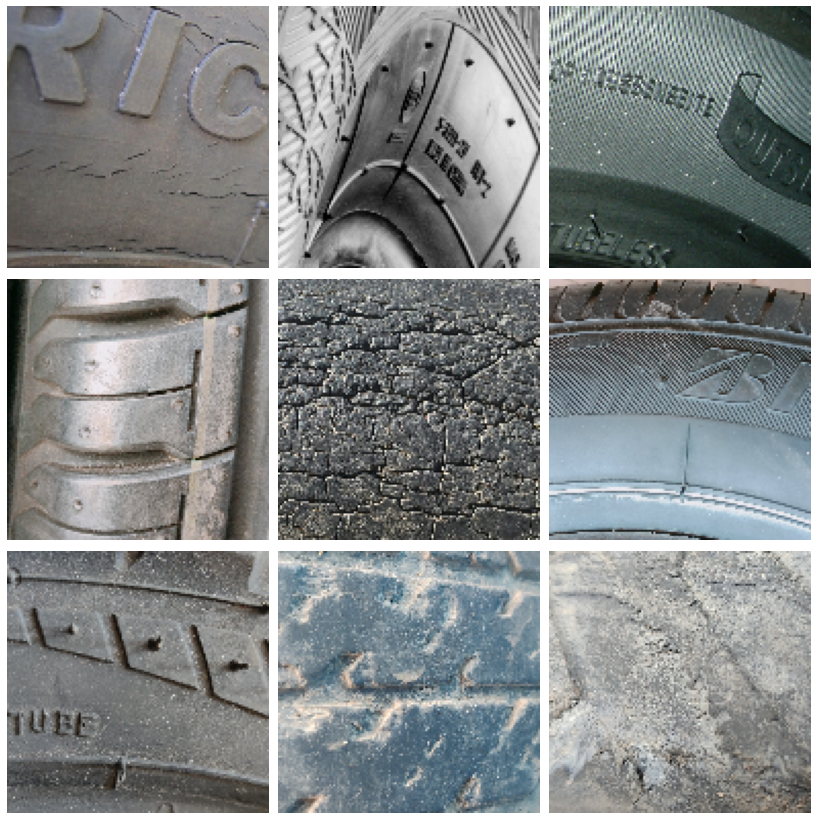

In [5]:
print(CLR + "Several Image Examples:")
images, labels = list(inefficient_dataset.take(1).as_numpy_iterator())[0]

plt.figure(figsize=(11.5, 11.5), tight_layout=True, facecolor="white")
for idx, (image, label) in enumerate(zip(images[:9], labels[:9]), start=1):
    plt.subplot(3, 3, idx)
    plt.imshow(image.astype(np.int32))
    plt.axis("off")

plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Example Images</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Here, I used <code>keras.utils.image_dataset_from_directory()</code> function to read the whole dataset and simultaneously centre and crop images to $128$x$128$ pixels. As we can see, we will be able to use augmentation since flipping or rotating these pictures couldn't change classification results. <b>On the other hand, when we translate the image, it could turn out that the effect is no longer visible, so this type of augmentation may be deceptive.</b><br><br>
    Now, let's have a look at dataset performance.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.2</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Dataset Inefficiency</span></b><a class="anchor" id="dataset_inefficiency"></a> [↑](#top)

In [6]:
bench_results = tfds.benchmark(inefficient_dataset.prefetch(AUTOTUNE), batch_size=32)



************ Summary ************



  0%|          | 0/58 [00:00<?, ?it/s]

Examples/sec (First included) 132.19 ex/sec (total: 1888 ex, 14.28 sec)
Examples/sec (First only) 12.99 ex/sec (total: 32 ex, 2.46 sec)
Examples/sec (First excluded) 157.04 ex/sec (total: 1856 ex, 11.82 sec)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Inefficient Dataset</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>This dataset is completely inefficient.</b> Obviously, it's easy to read and feed the neural network, but learning will be ineffective and take a lot of time. It's much better to serialize images in <code>tfrecord</code> format. <b>This step requires a little coding, but we get a highly performed dataset at the end.</b> Let's deal with it right now.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Preparing Efficient Datasets with TFRecord</span></b><a class="anchor" id="preparing_efficient_datasets_with_tfrecord"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In this section, we will prepare highly efficient datasets based on the <code>tfrecord</code> format. <b>This way there will be no bottleneck related to reading the data and learning should be fast, even for CNN.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Serialize Images to TFRecord</span></b><a class="anchor" id="serialize_images_to_tfrecord"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    TFRecord format is preferable when dealing with a large amount of data. It usually contains serialized buffer protocols (so-called protobufs). In TensorFlow, the primary buffer protocol is <code>Example</code>, which represents precisely one sample from the dataset. <code>Example</code> contains a list of named features, where each feature may be a bytes, float, or int list. When we define an <code>Example</code>, we can then serialize it to a string and save it. Let's have a look at this.
</p>

In [637]:
def serialize_images_to_tfrecord(
    image_paths, labels, filename, /, size=(128, 128), compression=None
):
    height, width = size
    options = tf.io.TFRecordOptions(compression_type=compression)
    resizing = layers.Resizing(height=height, width=width, crop_to_aspect_ratio=True)

    with tf.io.TFRecordWriter(filename, options) as f:
        for image_path, label in zip(image_paths, labels):
            image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
            image_resized = tf.cast(resizing(image), dtype=tf.uint8)
            image_encoded = tf.io.encode_jpeg(image_resized)
            example = Example(
                features=Features(
                    feature={
                        "image": Feature(bytes_list=BytesList(value=[image_encoded.numpy()])),
                        "label": Feature(int64_list=Int64List(value=[label])),
                    }
                )
            )
            f.write(example.SerializeToString())


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Serialization Function</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    If you're new to the topic, the above function requires explanation. The <code>serialize_images_to_tfrecord()</code> function takes paths to images and their labels as lists. Moreover, it takes the file name to which to write the prepared dataset, and compression type of this file. Furthermore, it utilises preliminary preprocessing, i.e. cropping and centring the image to the desired size. To preprocess an example image, we decode it with <code>TensorFlow</code>, resize it and encode it again. Next, we define the <code>Example</code> protobuf and save the serialized image to <code>tfrecord</code>.
</p>

In [3]:
def get_train_valid_subsets(data_path, /, valid_ratio=0.2, seed=None):
    defective_paths = glob.glob(str(data_path / "defective/*"))
    good_paths = glob.glob(str(data_path / "good/*"))
    paths = np.concatenate((defective_paths, good_paths))

    defective_labels = [0] * len(defective_paths)
    good_labels = [1] * len(good_paths)
    labels = np.concatenate((defective_labels, good_labels))

    return train_test_split(
        paths, labels, test_size=valid_ratio, random_state=seed, stratify=labels
    )


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Training - Validation Split Function</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Here, we prepare lists with image paths and their labels. <b>Then, we split elements in a stratified fashion so that both training and validation datasets have the same ratio of negative and positive classes.</b>
</p>

In [635]:
train_paths, valid_paths, train_labels, valid_labels = get_train_valid_subsets(
    dataset_path, valid_ratio=0.125, seed=42
)

print(CLR + "Training Image Paths:\n")
print(train_paths[:3])
print("\nTraining Labels:", train_labels[:3])


Training Image Paths:

['data\\Digital images of defective and good condition tyres\\defective\\Defective (619).jpg'
 'data\\Digital images of defective and good condition tyres\\good\\good (678).jpg'
 'data\\Digital images of defective and good condition tyres\\defective\\Defective (411).jpg']

Training Labels: [0 1 0]


In [638]:
serialize_images_to_tfrecord(train_paths, train_labels, "train.tfrecord", compression="GZIP")
serialize_images_to_tfrecord(valid_paths, valid_labels, "valid.tfrecord", compression="GZIP")


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Serialization</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Now, we pass image paths and labels and allow the <code>serialize_images_to_tfrecord()</code> function to serialize pictures to <code>tfrecord</code> format.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Load Serialized Data</span></b><a class="anchor" id="load_serialize_data"></a> [↑](#top)

In [639]:
FEATURE_DESCR = {
    "image": tf.io.VarLenFeature(dtype=tf.string),
    "label": tf.io.FixedLenFeature(shape=[1], dtype=tf.int64),
}


def parse_example(serialized_example, /):
    example = tf.io.parse_single_example(serialized_example, FEATURE_DESCR)
    return tf.io.decode_jpeg(example["image"].values[0], channels=3), example["label"][0]


def get_dataset_from_tfrecord(
    filename,
    compression,
    /,
    batch_size=32,
    cache=True,
    shuffle=False,
    shuffle_buffer_size=256,
    seed=None,
):
    dataset = tf.data.TFRecordDataset(filename, compression_type=compression)
    dataset = dataset.map(parse_example, num_parallel_calls=AUTOTUNE)
    if cache:
        dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    dataset = dataset.batch(batch_size, num_parallel_calls=AUTOTUNE)
    return dataset.prefetch(AUTOTUNE)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Preparing Datasets</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The <code>get_dataset_from_tfrecord()</code> reads serialized data from the <code>tfrecord</code> format and prepares an efficient dataset. When the <code>tfrecord</code> file is loaded, we must map serialized images and labels with the <code>parse_example</code> function. As you can see, it processes serialized examples using the <i>FEATURE_DESCR</i> dictionary. Lastly, it returns the image and its label as a tuple. By default, the <code>VarLenFeature</code> feature is processed as a sparse tensor, so we retrieve data from the value attribute. The rest of the <code>get_dataset_from_tfrecord()</code> function carries out typical performance operations and returns the appropriate dataset. <b>Let's have a look at whether it works and how effective it is.</b>
</p>

In [640]:
batch_size = 32

train_ds = get_dataset_from_tfrecord(
    "train.tfrecord", "GZIP", batch_size=batch_size, shuffle=True, seed=42
)
valid_ds = get_dataset_from_tfrecord("valid.tfrecord", "GZIP", batch_size=batch_size)

tfds.benchmark(train_ds, batch_size=batch_size)



************ Summary ************



0it [00:00, ?it/s]

Examples/sec (First included) 5207.52 ex/sec (total: 1664 ex, 0.32 sec)
Examples/sec (First only) 289.04 ex/sec (total: 32 ex, 0.11 sec)
Examples/sec (First excluded) 7815.09 ex/sec (total: 1632 ex, 0.21 sec)


BenchmarkResult(stats=             duration  num_examples          avg
first+lasts  0.319538          1664  5207.524873
first        0.110711            32   289.041097
lasts        0.208827          1632  7815.092610, raw_stats=                       duration
start_time        543920.955384
first_batch_time  543921.066095
end_time          543921.274922
num_iter              51.000000)

Several Image Examples From Validation Dataset:


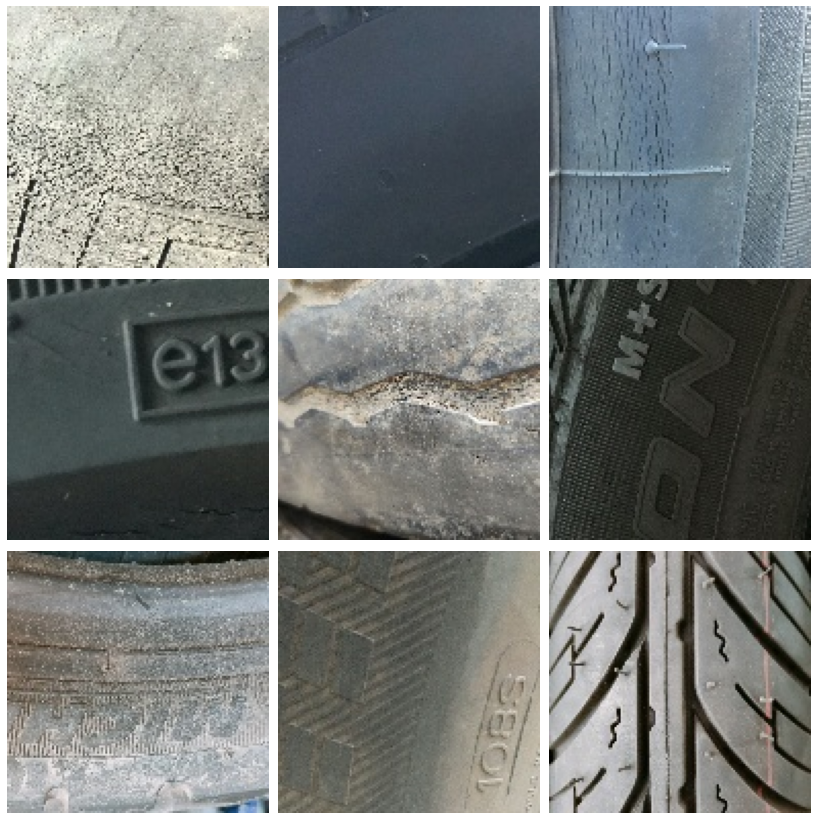

In [470]:
print(CLR + "Several Image Examples From Validation Dataset:")
efficient_ds = get_dataset_from_tfrecord("valid.tfrecord", "GZIP")
images, labels = list(efficient_ds.take(1).as_numpy_iterator())[0]

plt.figure(figsize=(11.5, 11.5), tight_layout=True, facecolor="white")
for idx, (image, label) in enumerate(zip(images[:9], labels[:9]), start=1):
    plt.subplot(3, 3, idx)
    plt.imshow(image.astype(np.int32))
    plt.axis("off")

plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Performance Is All You Need</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <b>As you can see, there is a huge boost to the performance! Now we don't need to bother about the data feeding bottleneck.</b> Since datasets are ready, we can get to the CNN!
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Simple Residual CNN</span></b><a class="anchor" id="simple_residual_cnn"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>About Section</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In this section, I will build a simple Residual CNN architecture, which should break around $88$% (at least I got such a result locally) of accuracy on the validation dataset. For this, I will implement the Residual Unit and the SE Unit. Moreover, I will test a few not-so-common elements like the depth pooling layer and Swish activation function with a trainable $\beta$ parameter. I'll try to tell a little about all of these components during their implementation.
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.1</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Residual CNN Components</span></b><a class="anchor" id="residual_cnn_components"></a> [↑](#top)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Generalized Swish Activation Function</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Here, I introduce a generalized Swish activation function: <a href="https://arxiv.org/abs/1710.05941"><b>Searching for Activation Functions</b></a>. As far as I know, the Swish function is available in <code>Keras</code> but without a trainable $\beta$ parameter. Swish generally should improve model performance, but it's more computationally demanding than typically used ReLU. If $\beta \rightarrow \infty$, then Swish is equivalent to ReLU. See below.
</p>

In [806]:
class GeneralizedSwish(keras.layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = tf.Variable(beta, trainable=kwargs.get("trainable", True), dtype=tf.float32)

    def call(self, inputs):
        return inputs / (1.0 + tf.exp(-self.beta * inputs))

    def get_config(self):
        return super().get_config() | {
            "beta": self.beta.numpy(),
        }


In [807]:
def swish(x, beta=1.0):
    return x / (1.0 + np.exp(-beta * x))


# Create figure
fig = go.Figure()
beta_sign = "\u03b2"
betas = np.arange(0, 5, 0.1)

# Add traces, one for each slider step
for beta in betas:
    fig.add_scatter(
        visible=False,
        line=dict(color="#633075", width=3),
        name="",
        x=np.arange(-4, 4, 0.01),
        y=swish(np.arange(-4, 4, 0.01), beta),
        hovertemplate="x=%{x}<br>\u03b2=" f"{beta}" "<br>y=Swish<sub>\u03b2</sub>(%{x})",
    )
fig.update_traces(opacity=0.75)

# Make 10th trace visible
fig.data[10].visible = True  # type: ignore

# Create and add slider
steps = []
for i, beta in enumerate(betas):  # type: ignore
    step = dict(
        method="update",
        label=f"{beta:.1f}",
        args=[
            {"visible": [False] * len(fig.data)},  # type: ignore
            {
                "title": "Generalized Swish Activation Function: "
                f"Swish<sub>{beta_sign}={beta:.1f}</sub>(x)"
            },
        ],
    )
    step["args"][0]["visible"][i] = True  # type: ignore Toggle i'th trace to "visible"
    steps.append(step)

sliders = [
    dict(
        active=10,
        currentvalue={"prefix": f"{beta_sign}: "},
        pad={"t": 50},
        steps=steps,
        bgcolor="rgba(68, 68, 68, 0.25)",
    )
]

fig.add_annotation(
    x=-3.8,
    y=2,
    align="left",
    xanchor="left",
    text=f"<b>We will allow CNN to learn the {beta_sign} parameter.</b>",
    showarrow=False,
)
fig.add_hline(y=0, line_width=2, line_dash="dash", line_color="rgba(68, 68, 68, 0.25)")
fig.add_vline(x=0, line_width=2, line_dash="dash", line_color="rgba(68, 68, 68, 0.25)")
fig.update_layout(
    font_color=FONT_COLOR,
    title=f"Generalized Swish Activation Function: Swish<sub>{beta_sign}={betas[10]:.1f}</sub>(x)",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    width=840,
    height=480,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_title="x",
    sliders=sliders,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>MaxDepthPool2D Layer</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    As we know, we usually use average pooling layers or max pooling layers in CNNs; nevertheless, I decided to use a depth pooling layer here. This solution isn't so common, but I'm just curious. <b>The point is that max op is performed along the depth dimension, and the network can learn invariance over different features.</b> For example, it can learn invariance to translations and rotations.
</p>

In [808]:
class MaxDepthPool2D(keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # The number of channels is stored in shape[-1].
        groups = shape[-1] // self.pool_size  # Number of channel groups.
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

    def get_config(self):
        return super().get_config() | {
            "pool_size": self.pool_size,
        }


In [809]:
np.random.seed(42)

# Kernel size must be a divisor of the number of input maps.
maps = np.random.randn(1, 28, 28, 32)
output = MaxDepthPool2D(pool_size=2)(maps)

print(f"{CLR}{'Maps Shape:':15s}", f"{MAGENTA}{maps.shape}")
print(f"{CLR}{'Output Shape:':15s}", f"{MAGENTA}{output.shape}")


Maps Shape:     (1, 28, 28, 32)
Output Shape:   (1, 28, 28, 16)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Squeeze-and-Excitation Connection</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Squeeze-and-Excitation block appeared first in the SENet architecture: <a href="https://arxiv.org/abs/1709.01507"><b>Squeeze-and-Excitation Networks</b></a>. SE block is composed of a small neural network which can be attached to, for example, a residual block. SE analyses the attached unit and focuses only on the depth dimension, simultaneously assessing which features are related in terms of activity. SE unit comprises a global average pooling layer, a hidden dense layer with ReLU activation function, and a dense output layer with sigmoid activation function. The hidden layer squeezes input to a small vector (for example, $8$ or $16$ times smaller than the input number of feature maps), whereas the output layer has the same size as the number of input feature maps. <b>This way, the SE unit calibrates the input matrix, where irrelevant feature maps are reduced.</b>
</p>

In [812]:
class SEUnit(layers.Layer):
    def __init__(self, squeeze_factor=16, hidden_activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.squeeze_factor = squeeze_factor
        self.hidden_activation = keras.activations.get(hidden_activation)

    def build(self, input_shape):
        n_units_dense = input_shape[-1] // self.squeeze_factor
        n_units_out = input_shape[-1]
        self.feed_forward = [
            # keepdims=True, because it must be broadcastable for multiplication.
            layers.GlobalAvgPool2D(keepdims=True),
            layers.Dense(n_units_dense, self.hidden_activation, kernel_initializer="he_normal"),
            layers.Dense(n_units_out, "sigmoid"),
        ]
        super().build(input_shape)

    def call(self, inputs):
        X = inputs
        for layer in self.feed_forward:
            X = layer(X)
        return X * inputs  # Calibrate feature maps.


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Residual Connection</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    In the residual connection, the input signal is added to the output of the layer placed above. This way, the network forwards a copy of the input to the output. In other words, firstly, it simulates the identity function. In the case when the desired function resembles the identity function, the learning process is significantly accelerated. Moreover, the signal can be propagated throughout the whole network.
</p>

In [813]:
DefaultConv2D = partial(
    layers.Conv2D,
    padding="same",
    use_bias=False,
    kernel_initializer="he_normal",
)


class SEResidualUnit(layers.Layer):
    def __init__(
        self, filters, kernel_size, strides=1, se_active=False, squeeze_factor=16, **kwargs
    ):
        super().__init__(**kwargs)
        self.se_active = se_active
        self.activation = GeneralizedSwish()
        self.se_unit = SEUnit(squeeze_factor)

        self.feed_forward = [
            DefaultConv2D(filters=filters, kernel_size=kernel_size, strides=strides),
            layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters=filters, kernel_size=kernel_size),
            layers.BatchNormalization(),
        ]

        self.shortcut_connection = []
        if strides > 1:
            self.shortcut_connection = [
                DefaultConv2D(filters=filters, kernel_size=1, strides=strides),
                layers.BatchNormalization(),
            ]

    def call(self, inputs):
        X, shortcut_X = inputs, inputs
        for layer in self.feed_forward:
            X = layer(X)
        for layer in self.shortcut_connection:
            shortcut_X = layer(shortcut_X)
        residual_unit_output = self.activation(X + shortcut_X)
        if self.se_active:
            return self.se_unit(residual_unit_output) + shortcut_X
        return residual_unit_output


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>1Cycle Scheduling</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    The cyclic learning rate (and also momentum) is an exciting learning rate scheduling technique for faster convergence: <a href="https://arxiv.org/abs/1708.07120"><b>Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates</b></a>. The working principle is relatively easy to understand. <b>We start with a given learning rate (usually $10$ times smaller than the maximum) and allow it to rise to the maximal value (where the solution diverges) roughly by the first half of training. In the second half, the learning rate drops as fast as it grew before, and for the last few epochs, we reduce it such that the final value is roughly $1000$ times lower than the starting learning rate.</b> On the other hand, the rule with cyclic momentum is inverted. We set the maximum and minimum values of momentum (usually to $0.95$ and $0.85$, respectively), but firstly it falls and then rises. There are at least two solutions. One of them is implemented using linear annealing (as depicted above). The second uses cosine annealing, which gives smooth curves. In this notebook, I'll use a cosine one, but the implementation allows you to test different approaches.<br><br>
    As you can see above, <code>OneCycleLearningRatePolicy</code> takes several parameters:
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    <li><code>max_lr</code> - maximum learning rate (we've just found it),</li>
    <li><code>start_factor</code> - factor by which multiply <code>max_lr</code> at the beginning of training,</li>
    <li><code>final_factor</code> - factor by which multiply <code>max_lr</code> at the final stage of training,</li>
    <li><code>max_momentum</code> - max value of momentum,</li>
    <li><code>min_momentum</code> - min value of momentum,</li>
    <li><code>cycle_momentum</code> - whether cycle momentum or not,</li>
    <li><code>pct_up</code> - percentage value of training time where learning rate rises and momentum drops,</li>
    <li><code>annealing</code> - annealing function (cosine or linear),</li>
    <li><code>n_batches</code> - number of batches per epoch. Need to be specified if a dataset is read from a file.</li>
</ul>

In [814]:
class OneCycleLearningRatePolicy(keras.callbacks.Callback):
    """Implementation of One Cycle Learning Rate Policy - https://arxiv.org/abs/1708.07120."""

    def __init__(
        self,
        max_lr,
        start_factor=1e-1,
        final_factor=1e-4,
        max_momentum=0.95,
        min_momentum=0.85,
        cycle_momentum=False,
        pct_up=0.3,
        annealing="cosine",
        n_batches=None,
    ):
        if not annealing in ("cosine", "linear"):
            raise ValueError("Invalid annealing type. Choose 'cosine' or 'linear'!")
        self.max_lr = max_lr
        self.start_lr = max_lr * start_factor
        self.final_lr = max_lr * final_factor
        self.max_momentum = max_momentum
        self.min_momentum = min_momentum
        self.cycle_momentum = cycle_momentum
        self.pct_up = pct_up
        self.learning_rates = []
        self.momentum_rates = []
        self.n_batches = n_batches
        self._anneal_func = getattr(self, "_" + annealing + "_anneal")
        self._momentum_attrs = ("momentum", "beta_1")
        self._current_step = 0

    def on_train_begin(self, logs=None):
        if self.params["steps"] is None:
            self.params["steps"] = self.n_batches
        if self.params["steps"] is None:
            raise ValueError("Number of batches is not specified. Specify `n_batches`!")

        self._steps_total = self.params["steps"] * self.params["epochs"]
        self._steps_up = int(self._steps_total * self.pct_up)
        self._steps_down = self._steps_total - self._steps_up

        opt = self.model.optimizer
        self._momentum = next(
            (getattr(opt, attr) for attr in self._momentum_attrs if hasattr(opt, attr)), None
        )
        if self.cycle_momentum and self._momentum is None:
            self.cycle_momentum = False
            warnings.warn("This optimizer does not support momentum! Cycling disabled.")

    def on_batch_begin(self, batch, logs=None):
        if self._current_step <= self._steps_up:
            pct = self._current_step / self._steps_up
            learning_rate = self._anneal_func(self.start_lr, self.max_lr, pct)
            momentum = self._anneal_func(self.max_momentum, self.min_momentum, pct)
        else:
            pct = (self._current_step - self._steps_up) / self._steps_down
            learning_rate = self._anneal_func(self.max_lr, self.final_lr, pct)
            momentum = self._anneal_func(self.min_momentum, self.max_momentum, pct)

        K.set_value(self.model.optimizer.learning_rate, learning_rate)
        if self.cycle_momentum:
            K.set_value(self._momentum, momentum)

        self.learning_rates.append(learning_rate)
        self.momentum_rates.append(momentum)
        self._current_step += 1

    def _cosine_anneal(self, lr1, lr2, pct):
        return lr2 + (lr1 - lr2) * (np.cos(np.pi * pct) + 1.0) * 0.5

    def _linear_anneal(self, lr1, lr2, pct):
        return lr1 + (lr2 - lr1) * pct


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Colorama Verbose Callback</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Colorama callback should prettify the output a little.
</p>

In [815]:
class ColoramaVerbose(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f"{CLR}Epoch: {MAGENTA}{epoch + 1:02d}{CLR} -",
            f"{CLR}loss: {MAGENTA}{logs['loss']:.5f}{CLR} -",
            f"{CLR}accuracy: {MAGENTA}{logs['accuracy']:.5f}{CLR} -",
            f"{CLR}val_loss: {MAGENTA}{logs['val_loss']:.5f}{CLR} -",
            f"{CLR}val_accuracy: {MAGENTA}{logs['val_accuracy']:.5f}",
        )


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Everything Ready</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    As you can see, there we have several components. You can probably reach a relatively good score with simple CNN, but I just like coding from scratch and experimenting with different solutions. <b>Now, we can put it all together.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">3.2</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Residual CNN Architecture &amp; Training</span></b><a class="anchor" id="residual_cnn_architecture_and_training"></a> [↑](#top)

In [816]:
K.clear_session()
keras.utils.set_random_seed(42)

augmentation_and_rescaling = keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomRotation(factor=0.2, seed=42),
        layers.RandomContrast(factor=0.4, seed=42),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1.0),
    ]
)

residual_cnn = keras.Sequential(
    [
        DefaultConv2D(filters=64, kernel_size=5),
        layers.BatchNormalization(),
        GeneralizedSwish(),
        layers.MaxPool2D(pool_size=2, padding="valid"),
        layers.BatchNormalization(),
        #
        SEResidualUnit(filters=128, kernel_size=3, strides=2, se_active=True),
        MaxDepthPool2D(pool_size=2),
        layers.MaxPool2D(pool_size=2, padding="valid"),
        layers.BatchNormalization(),
        #
        layers.Flatten(),
        #
        layers.Dense(256, use_bias=False, kernel_initializer="he_normal"),
        layers.BatchNormalization(),
        GeneralizedSwish(),
        layers.Dropout(0.4),
        #
        layers.Dense(256, use_bias=False, kernel_initializer="he_normal"),
        layers.BatchNormalization(),
        GeneralizedSwish(),
        layers.Dropout(0.4),
        #
        layers.Dense(1, activation="sigmoid"),
    ]
)

cnn_model = keras.Sequential([augmentation_and_rescaling, residual_cnn])
cnn_model.build(input_shape=(None, 128, 128, 3))


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Simple Residual CNN</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Firstly, here we have the default convolutional layer, after which we resize the image two times by max pooling op. Next, we add a residual connection with the SE block. This is the primary layer in the architecture. It resizes the image two times but doubles the number of feature maps. Moreover, the SE block should reduce the weights of feature maps that are not significant. After that, I decided to include max op in both versions by depth and spatial dimensions. Next, we flatten the output (at this stage, images are $16$x$16$ pixels) and use two dense layers with $40$% of the dropout.
</p>


In [817]:
# Specify n_batches by hand for 1Cycle, since dataset is read from file.
n_batches = np.ceil(len(train_labels) / batch_size).astype(int)
n_epochs = 50
patience = 10
max_lr = 2e-4

optimizer = keras.optimizers.Nadam(clipnorm=1.0)
cnn_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
one_cycle = OneCycleLearningRatePolicy(max_lr, cycle_momentum=False, n_batches=n_batches)
early_stopping = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
colorama = ColoramaVerbose()

history = cnn_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=n_epochs,
    callbacks=[one_cycle, early_stopping],
    # verbose=False,
)


Epoch 1/50


51/51 [==============================] - 9s 99ms/step - loss: 0.7866 - accuracy: 0.5400 - val_loss: 0.6518 - val_accuracy: 0.6293
Epoch 2/50
51/51 [==============================] - 5s 89ms/step - loss: 0.7130 - accuracy: 0.5973 - val_loss: 0.6083 - val_accuracy: 0.6724
Epoch 3/50
51/51 [==============================] - 5s 88ms/step - loss: 0.6854 - accuracy: 0.6139 - val_loss: 0.5929 - val_accuracy: 0.6638
Epoch 4/50
51/51 [==============================] - 5s 89ms/step - loss: 0.6522 - accuracy: 0.6379 - val_loss: 0.5655 - val_accuracy: 0.6983
Epoch 5/50
51/51 [==============================] - 5s 89ms/step - loss: 0.6226 - accuracy: 0.6626 - val_loss: 0.5415 - val_accuracy: 0.7586
Epoch 6/50
51/51 [==============================] - 5s 88ms/step - loss: 0.6217 - accuracy: 0.6872 - val_loss: 0.5293 - val_accuracy: 0.7328
Epoch 7/50
51/51 [==============================] - 4s 88ms/step - loss: 0.6254 - accuracy: 0.6675 - val_loss: 0.5047 - val_accuracy: 0.7759
Epoch 8/50
51/51 [======

In [823]:
fig = px.line(
    pd.DataFrame(history.history),
    labels={"value": "", "index": "Epoch", "variable": "Variable"},
    title="Residual CNN - Training Process",
    line_dash="variable",
    line_dash_sequence=["solid", "solid", "dashdot", "dashdot"],
    color="variable",
    color_discrete_sequence=["#4A4B52", "#4A4B52", "#633075", "#633075"],
    height=480,
    width=840,
)
fig.add_hline(y=0.9, line_width=1.75, line_dash="dash", line_color="rgba(68, 68, 68, 0.25)")
fig.update_traces(line_width=1.75, opacity=0.8)
fig.update_xaxes(showgrid=False, range=(-1, 51))
fig.update_yaxes(showgrid=False, range=(0.2, 0.95))
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()

# ------------------------------------------
one_cycle_rates = pd.DataFrame(
    {
        "Step": range(len(one_cycle.learning_rates)),
        "Learning Rate": one_cycle.learning_rates,
        "Momentum Rate": one_cycle.momentum_rates,
    }
)

fig = make_subplots(
    rows=1,
    cols=2,
    x_title="Training Step",
    y_title="Value",
    subplot_titles=("Learning Rate", "Momentum (beta_1) Rate"),
)
fig.update_annotations(font_size=14)

fig.add_scatter(
    x=one_cycle_rates["Step"],
    y=one_cycle_rates["Learning Rate"],
    name="Learning Rate",
    line=dict(color="#633075"),
    row=1,
    col=1,
)
fig.add_scatter(
    x=one_cycle_rates["Step"],
    y=one_cycle_rates["Momentum Rate"],
    name="Momentum Rate",
    line=dict(color="#633075"),
    row=1,
    col=2,
)
fig.update_traces(opacity=0.75)
fig.update_xaxes(
    range=(-one_cycle_rates.Step.max() * 0.05, one_cycle_rates.Step.max() * 1.1), showgrid=False
)
fig.update_yaxes(
    range=(
        -one_cycle_rates["Learning Rate"].max() * 0.05,
        one_cycle_rates["Learning Rate"].max() * 1.1,
    ),
    row=1,
    col=1,
    showgrid=False,
)
fig.update_yaxes(range=(0.84, 0.96), row=1, col=2, showgrid=False)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    height=420,
    width=840,
    title_text="Residual CNN - Nadam Optimizer 1Cycle Scheduling",
    showlegend=False,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>CNN Evaluation Results</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Now, we could have evaluated the model as usual in test mode. Nevertheless, such an approach will vary, and we get different results fluctuating around $84$% - $85$% on the validation dataset. Here, I want to introduce a powerful regularization technique, i.e. <b>Monte Carlo Regularization.</b> The point is that the <code>Dropout</code> layer remains active during prediction, so that all predictions will differ slightly. We can collect, for example, $100$ predictions and calculate mean probabilities. In this way, we get a more reliable estimation. To do this, we must swap <code>Dropout</code> layers with <code>MCDropout</code> layers that remain active during prediction. The whole process looks as below. 
</p>

In [824]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs, training=None):
        # Dropout remains active during prediction.
        return super().call(inputs, training=True)


In [825]:
K.clear_session()
keras.utils.set_random_seed(42)

mc_cnn_model = keras.Sequential(
    [
        augmentation_and_rescaling,
        *[
            MCDropout(layer.rate) if isinstance(layer, keras.layers.Dropout) else layer
            for layer in residual_cnn.layers
        ],
    ]
)
mc_cnn_model.build(input_shape=(None, 128, 128, 3))
mc_cnn_model.set_weights(cnn_model.get_weights())

mc_proba = [mc_cnn_model.predict(valid_ds, verbose=0).flatten() for _ in range(100)]
mc_valid_proba = np.stack(mc_proba, axis=1).mean(axis=1)
mc_valid_results = np.where(mc_valid_proba > 0.5, 1, 0)

mc_accuracy = (mc_valid_results == valid_labels).sum() / len(valid_labels)
print(f"{CLR}{'Monte Carlo Valid Accuracy:':30s}", f"{MAGENTA}{mc_accuracy:.5f}")


Monte Carlo Valid Accuracy:    0.87500


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
    border-bottom: 2px solid #633075;
">
    <b>Monte Carlo Assessment</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    We gather probabilities from $100$ different predictions since dropout is active, even in evaluation mode. <b>In this way, we get the Monte Carlo assessment, which should be more robust and generalize better.</b>
</p>

In [826]:
scores = {}

scores["Accuracy"] = accuracy_score(valid_labels, mc_valid_results)
scores["Precision"] = precision_score(valid_labels, mc_valid_results)
scores["Recall"] = recall_score(valid_labels, mc_valid_results)
scores["Specificity"] = recall_score(valid_labels, mc_valid_results, pos_label=0)
scores["F1"] = f1_score(valid_labels, mc_valid_results)
scores["ROC-AUC"] = roc_auc_score(valid_labels, mc_valid_proba)
metrics_for_bar = pd.DataFrame(scores, index=["Value"]).T

scores["ConfusionMatrix"] = confusion_matrix(valid_labels, mc_valid_results)
scores["FPR-TPR-Threshold"] = roc_curve(valid_labels, mc_valid_proba)


fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{}, {}], [{"colspan": 2}, None]],
)

fig.add_scatter(
    x=scores["FPR-TPR-Threshold"][0],
    y=scores["FPR-TPR-Threshold"][1],
    name="",
    mode="markers+lines",
    line_color="#010D36",
    marker=dict(size=6, color="#633075", opacity=0.8, symbol="x"),
    showlegend=False,
    row=1,
    col=1,
)
fig.add_scatter(
    x=[0, 1],
    y=[0, 1],
    name="",
    mode="lines",
    line=dict(dash="longdash", color="#010D36"),
    showlegend=False,
    row=1,
    col=1,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="True Positive Rate (Recall)",
    row=1,
    col=1,
)
fig.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="False Positive Rate (Fall-Out)",
    row=1,
    col=1,
)

fig.add_heatmap(
    z=scores["ConfusionMatrix"],
    x=["Defective", "Good"],
    y=["Defective", "Good"],
    name="",
    text=scores["ConfusionMatrix"],
    texttemplate="%{text}",
    xgap=20,
    ygap=20,
    showscale=False,
    colorscale=[[0.0, "#4A4B52"], [1.0, "#633075"]],
    row=1,
    col=2,
)
fig.update_yaxes(title="True Label", autorange="reversed", tickangle=-90, row=1, col=2)
fig.update_xaxes(title="Predicted Label", row=1, col=2)

fig.add_bar(
    x=metrics_for_bar.Value,
    y=metrics_for_bar.index,
    name="",
    texttemplate="%{x:.2f}",
    hovertemplate="%{y}<br>%{x:.5f}",
    marker_color="#4A4B52",
    showlegend=False,
    orientation="h",
    width=0.7,
    row=2,
    col=1,
)
fig.update_yaxes(categoryorder="total ascending", row=2, col=1)
fig.update_xaxes(title="Value", range=(-0.02, 1.0), row=2, col=1)

fig.update_layout(
    font_color=FONT_COLOR,
    title="CNN - Classification Summary",
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    height=840,
    width=840,
)
fig.show()


# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">4</span> <span style='color: #633075'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Summary</span></b><a class="anchor" id="summary"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    As for now, that's all in this notebook. I hope you like it, and if yes, then leave an upvote. If you have any questions, let me know in the comments section. Moreover, I encourage you to check my other notebooks. Thanks, and good luck!
</p>